In [137]:
audio_path = "audio-data/drumloop2.mp3"
name = "drumloop2"

# segmentation
block_length = 1 # number of frames in a stream block
BPM = 120
beat = 1 / 8 # metered divisions
hop_beats = 1 / 8 # hop length in beats
## alternatively, you can specify frame length and hop length in seconds
# frame_length_s = 0.1
# hop_length_s = 0.02
## or in samples
# frame_length = 4096
# hop_length = 1024

# clustering
n_classes = 4
maxlen = 8
# model architecture and training
step = 1 # step size for sliding window
hidden_units = 24 # number of hidden units in GRU layer
epochs = 100
batch_size = 16
validation_split = 0.2
patience = 15 # number of epochs to wait before early stopping

# utility
verbose = 1 # print additional information
directory = "."

In [138]:
# import dependencies
import argparse
from pathlib import Path
import math
import numpy as np, matplotlib.pyplot as plt, librosa
import librosa.display
# import IPython.display
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import GRU
from keras.callbacks import EarlyStopping
import json
from numpyencoder import NumpyEncoder
from sklearn import preprocessing, cluster
from streamer import Streamer
import scipy
from keras.utils import to_categorical
from keras import Sequential

if BPM is None and beat is not None or BPM is not None and beat is None:
    print("Please specify both BPM and beat if you are using metered divisions.")
    exit()
frame_length_s = (4 * beat * 60 / BPM) if BPM is not None else args.frame_length_s
hop_length_s = (4 * hop_beats * 60 / BPM) if BPM is not None else args.hop_length_s
sr = librosa.get_samplerate(audio_path)
frame_length = math.ceil(frame_length_s * sr) if frame_length_s is not None else args.frame_length
hop_length = math.ceil(hop_length_s * sr) if hop_length_s is not None else args.hop_length
stream = Streamer(audio_path, block_length, frame_length, hop_length)


In [139]:
# helper function to extract features from audio block
def extract_features(y, sr):
    zcr = [librosa.zero_crossings(y).sum()]
    energy = [scipy.linalg.norm(y)]
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwith = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    m_centroid = np.median(spectral_centroid, axis=1)
    m_bandwith = np.median(spectral_bandwith, axis=1)
    m_flatness = np.median(spectral_flatness, axis=1)
    m_rolloff = np.median(spectral_rolloff, axis=1)
    if y.size >= 2048:  
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, center=False) # mfccs
    else:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=len(y), hop_length=len(y), center=False)
    
    m_mfccs = np.median(mfccs[1:], axis=1)
    if m_mfccs.size == 0:
        print("Empty frame!")
        return None
    else:        
        features = np.concatenate((zcr, energy, m_centroid, m_bandwith, m_flatness, m_rolloff, m_mfccs))
        return features

In [140]:

# # helper function to extract features from audio block
# def extract_features(y, sr):
#     # zcr = [librosa.zero_crossings(y).sum()]
#     # energy = [scipy.linalg.norm(y)]  
#     # features = np.concatenate((zcr, energy))
#     if y.size >= 2048:  
#         mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, center=False) # mfccs
#     else:
#         mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=len(y), hop_length=len(y), center=False)
    
#     m_mfccs = np.median(mfccs, axis=1)
#     features = m_mfccs
#     return features

Audio length: 192.0s, 9216000 samples
Sample rate: 48000 Hz
Frame length: 0.25s,  12000 samples
Hop length: 0.25s, 12000 samples
Block length: 1 frame(s)
Number of blocks: 768
(768, 18)
(768, 18)
[-1.20912548 -0.70367295 -1.40830221 -1.75501487 -0.78510325 -1.52416177
 -1.08109916 -0.93250422 -1.67116297 -1.02150858 -1.26397981 -1.16350423
 -1.55860403 -1.46469779 -1.67957673 -1.36224387 -1.20178167 -1.46839212]
[1.6756064  1.72797858 1.33090008 0.8084763  2.00051128 1.01289278
 1.0638992  1.67663802 0.904818   1.6500955  1.20020867 1.29995843
 1.2125082  1.46927717 1.4785515  1.46298534 1.79257932 1.33017799]
[-1.12692823  1.72750412 -1.40830221 -1.70239536 -0.78509724 -1.52416177
  0.96740243  1.66021017  0.82655345  1.62735598  0.88659916  1.22015238
  0.70937408  1.32903366  0.54753142  1.35847161 -0.20515291  1.27720662]


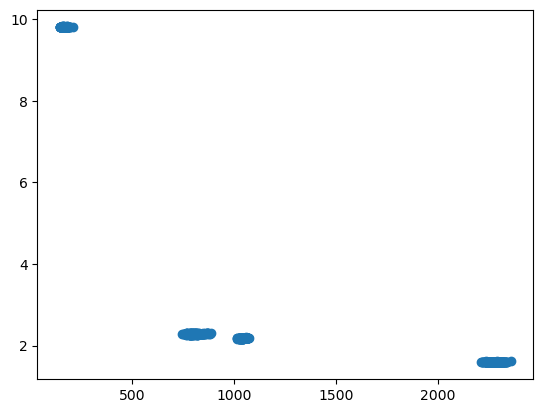

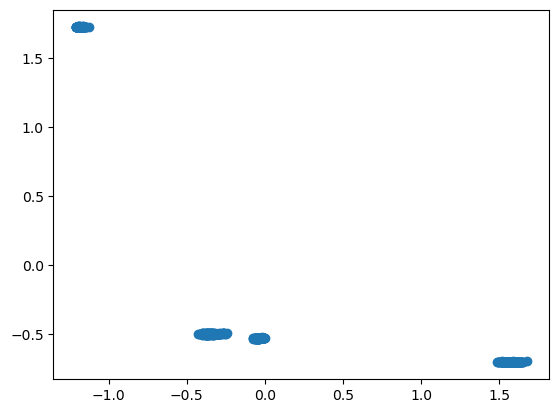

In [141]:


print(f"Audio length: {stream.length}s, {stream.n_samples} samples")
print(f"Sample rate: {sr} Hz")
print(f"Frame length: {frame_length_s}s,  {frame_length} samples")
print(f"Hop length: {hop_length_s}s, {hop_length} samples")
print(f"Block length: {block_length} frame(s)")
print(f"Number of blocks: {len(stream)}")

# extract features from each block in audio stream
features = np.array([extract_features(block, sr) for block in stream.new()])
# features_scaled = features
features_scaled = preprocessing.scale(features, axis=0) # should it be axis 0 then not 1??
if verbose:
    # print(features[0])
    print(features.shape)
    print(features_scaled.shape)
    print(features_scaled.min(axis=0))
    print(features_scaled.max(axis=0))
    print(features_scaled[0]) # type: ignore
if verbose:
    plt.scatter(features[:,0], features[:,1], ) # type: ignore
    # plt.xlabel('MFCC0 (scaled)')
    # plt.ylabel('MFCC1 Centroid (scaled)')   
    plt.show()
    plt.scatter(features_scaled[:,0], features_scaled[:,1], ) # type: ignore
    plt.show()

In [142]:
# cluster features
# frames = [frame for frame in frames if frame.size != 0] # remove empty
c_model = cluster.KMeans(n_clusters=n_classes, n_init='auto')
labels = c_model.fit_predict(features_scaled)

n_labels = len(np.unique(labels))
labels = labels.tolist()
if verbose:
    print(f"Total labelled frames: {len(labels)}")
    print(f"n_labels: {n_labels} (sanity check)")

frames = []
for i, block in enumerate(stream.new()):
    frames.append([i * hop_length, i * hop_length + frame_length])
# frames # sanity check

# each dict value has to be a 1D interlaved array, as Max dict object has trouble reading 2D arrays
# start sample is always stored at an even index and is followed by end sample
labelled_frames = dict()
for label, frame in zip(labels, frames):
    if label not in labelled_frames:
        labelled_frames[label] = []
    labelled_frames[label].extend(frame) # use extend instead of append
if verbose:    
    print(len(labelled_frames[0])) # sanity check
    print(labelled_frames[0][0], labelled_frames[0][1]) # sanity check

# build a subsequence for every <step> frames
# and a corresponding label that follows it
x = [] # these will be features
y = [] # these will be targets
for i in range(0, len(labels) - maxlen, step):
    x.append(labels[i: i + maxlen])
    y.append(labels[i + maxlen])
# x_ = np.array(features)
# y_ = np.array(targets)
# one-hot encode features and targets
x_ = to_categorical(x, dtype ="bool")
y_ = to_categorical(y, dtype ="bool")
# sanity check
if verbose:
    print(x_.shape)
    print(y_.shape)

Total labelled frames: 768
n_labels: 4 (sanity check)
384
24000 36000
(760, 8, 4)
(760, 4)


In [143]:
x_[0]

array([[False, False,  True, False],
       [False,  True, False, False],
       [ True, False, False, False],
       [False, False, False,  True],
       [False, False,  True, False],
       [False,  True, False, False],
       [ True, False, False, False],
       [False, False, False,  True]])

In [144]:
# adapted from code by Lukas Biewald
# https://github.com/lukas/ml-class/blob/master/projects/7-text-generation/char-gen.py

inputs = Input(shape=(maxlen, n_labels))
x = GRU(hidden_units)(inputs)
outputs = Dense(n_labels, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model._name = name
es = EarlyStopping(monitor='val_loss', patience=patience)
model.compile(
    loss='categorical_crossentropy', # since we are using one-hot encoded labels
    optimizer="adam",
    metrics=['accuracy']
    )
model.summary()

history = model.fit(
    x_,
    y_,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=0.2,
    callbacks=[es]
)

Model: "drumloop2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 8, 4)]            0         
                                                                 
 gru_17 (GRU)                (None, 24)                2160      
                                                                 
 dense_16 (Dense)            (None, 4)                 100       
                                                                 
Total params: 2,260
Trainable params: 2,260
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
38/38 [==============================] - 2s 25ms/step - loss: 1.3863 - accuracy: 0.2007 - val_loss: 1.3377 - val_accuracy: 0.5000
Epoch 2/100
38/38 [==============================] - 1s 16ms/step - loss: 1.2950 - accuracy: 0.6332 - val_loss: 1.2466 - val_accuracy: 0.7500
Epoch 3/100
38/38 [================

In [145]:
path = Path(directory + "/models/" + name)
print(f"Saving model to: {path}")
path.mkdir(exist_ok=True, parents=True)
model_path = path / (name + ".keras")
model.save(model_path)
d_path = path / (name + "_frames.json")
d_path.write_text(json.dumps(labelled_frames, cls=NumpyEncoder))
config = dict()
config["filename"] = audio_path.split('/')[-1]
config["sr"] = sr
config["BPM"] = BPM
config["beat"] = beat
config["n_classes"] = int(n_classes)
config["maxlen"] = int(maxlen)
config["onset_detection"] = False
config["hop_length"] = hop_length
config["frame_length"] = frame_length
config["block_length"] = block_length
c_path = path / (name + "_config.json")    
c_path.write_text(json.dumps(config))
if verbose:
    print(f"Saved model to: {model_path}")
    print(f"Saved frames to: {d_path}")
    print(f"Saved config to: {c_path}")
print(f"Total epochs : {len(history.history['loss'])}")
print(history.history['val_loss'][-1])

Saving model to: models/drumloop2
Saved model to: models/drumloop2/drumloop2.keras
Saved frames to: models/drumloop2/drumloop2_frames.json
Saved config to: models/drumloop2/drumloop2_config.json
Total epochs : 100
0.00038809984107501805


In [146]:
labelled_frames[0]

[24000,
 36000,
 72000,
 84000,
 120000,
 132000,
 168000,
 180000,
 216000,
 228000,
 264000,
 276000,
 312000,
 324000,
 360000,
 372000,
 408000,
 420000,
 456000,
 468000,
 504000,
 516000,
 552000,
 564000,
 600000,
 612000,
 648000,
 660000,
 696000,
 708000,
 744000,
 756000,
 792000,
 804000,
 840000,
 852000,
 888000,
 900000,
 936000,
 948000,
 984000,
 996000,
 1032000,
 1044000,
 1080000,
 1092000,
 1128000,
 1140000,
 1176000,
 1188000,
 1224000,
 1236000,
 1272000,
 1284000,
 1320000,
 1332000,
 1368000,
 1380000,
 1416000,
 1428000,
 1464000,
 1476000,
 1512000,
 1524000,
 1560000,
 1572000,
 1608000,
 1620000,
 1656000,
 1668000,
 1704000,
 1716000,
 1752000,
 1764000,
 1800000,
 1812000,
 1848000,
 1860000,
 1896000,
 1908000,
 1944000,
 1956000,
 1992000,
 2004000,
 2040000,
 2052000,
 2088000,
 2100000,
 2136000,
 2148000,
 2184000,
 2196000,
 2232000,
 2244000,
 2280000,
 2292000,
 2328000,
 2340000,
 2376000,
 2388000,
 2424000,
 2436000,
 2472000,
 2484000,
 25200